
# Adult Census Income — Classification Capstone (Session 6)

Income classification model on the Adult Census dataset.

**Steps**

1. Load data and audit missing/`?` values  
2. Univariate analysis (bar/distribution/pie charts)  
3. Bivariate analysis (countplots & correlation heatmap)  
4. Preprocess (label-encode categoricals, scale numerics, handle imbalance)  
5. Train/test split (80/20, `random_state=42`)  
6. Train 6 models (LogReg, KNN, SVM, Naive Bayes, Decision Tree, Random Forest)  
7. Evaluate (Accuracy & F1); pick best; save artifacts  
8. Cross-validation & basic hyperparameter tuning



In [2]:

# --- Setup
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Try to import imblearn; if not present, we'll skip oversampling with a clear message.
try:
    from imblearn.over_sampling import RandomOverSampler
    IMB_AVAILABLE = True
except Exception as e:
    print("imblearn not available. To install: pip install imbalanced-learn")
    IMB_AVAILABLE = False

import joblib
#df = pd.read_csv(r'C:\Users\kgjam\OneDrive\Desktop\StackAcademy\Assignments\adultcensusincome.csv')
DATA_PATH = r"C:\Users\kgjam\OneDrive\Desktop\StackAcademy\Assignments\adultcensusincome.csv"
SAVE_DIR  = "/mnt/data"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Data path exists:", os.path.exists(DATA_PATH))


Data path exists: True


## 1) Load the dataset and audit

In [3]:

# Load data
df = pd.read_csv(DATA_PATH)

# Standardize column names: strip spaces
df.columns = [c.strip() for c in df.columns]

print("Shape:", df.shape)
display(df.head(3))

print("\nInfo:")
print(df.info())

# Count '?' as missing, common in Adult dataset
df = df.applymap(lambda x: np.nan if isinstance(x, str) and x.strip() == "?" else x)

print("\nMissing values by column:")
display(df.isna().sum())

# Trim string columns to remove stray spaces
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# Target distribution
print("\nTarget distribution (Income):")
display(df['income'].value_counts(dropna=False))


Shape: (32561, 14)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Female,0,4356,40,United-States,<=50K



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital.gain    32561 non-null  int64 
 10  capital.loss    32561 non-null  int64 
 11  hours.per.week  32561 non-null  int64 
 12  native.country  32561 non-null  object
 13  income          32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB
None

Missing values by column:


age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


Target distribution (Income):


income
<=50K    24720
>50K      7841
Name: count, dtype: int64

## 2) Univariate analysis

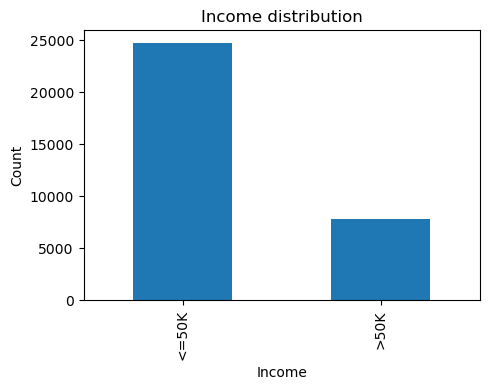

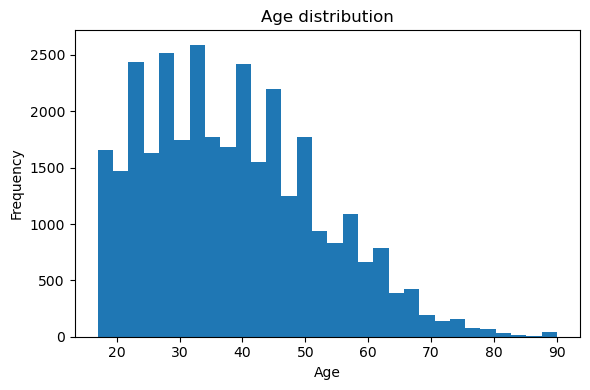

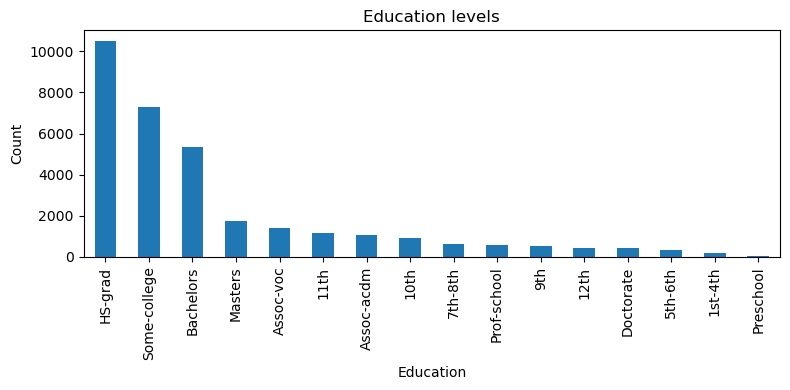

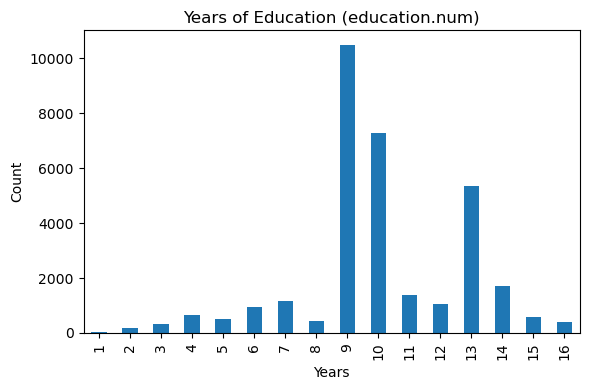

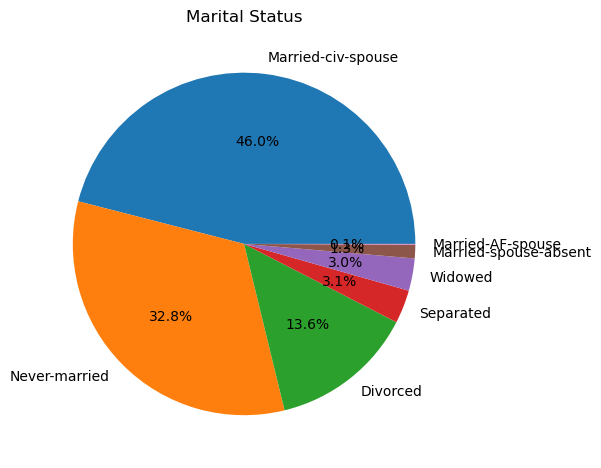

In [4]:

# Barplot for Income
plt.figure(figsize=(5,4))
df['income'].value_counts().plot(kind='bar')
plt.title('Income distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Distribution for Age
plt.figure(figsize=(6,4))
df['age'].dropna().plot(kind='hist', bins=30)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Barplot for Education
plt.figure(figsize=(8,4))
df['education'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Education levels')
plt.xlabel('Education')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Barplot for Years of Education (education.num)
if 'education.num' in df.columns:
    plt.figure(figsize=(6,4))
    df['education.num'].value_counts().sort_index().plot(kind='bar')
    plt.title('Years of Education (education.num)')
    plt.xlabel('Years')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'education.num' not found. Check dataset columns:", list(df.columns))

# Pie chart for Marital Status
if 'marital.status' in df.columns:
    plt.figure(figsize=(6,6))
    df['marital.status'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Marital Status')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'marital.status' not found. Check dataset columns:", list(df.columns))


## 3) Bivariate analysis

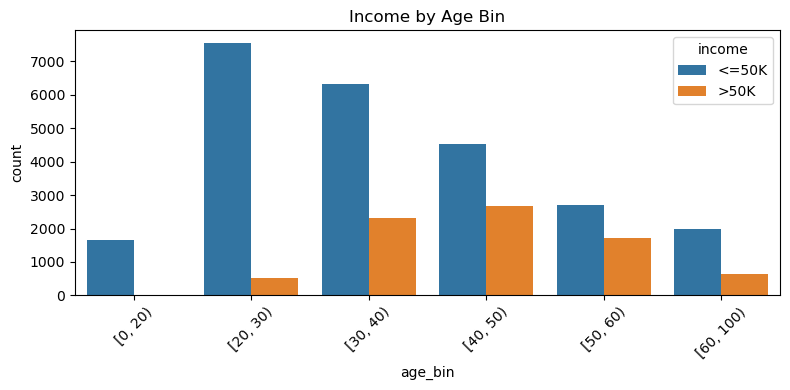

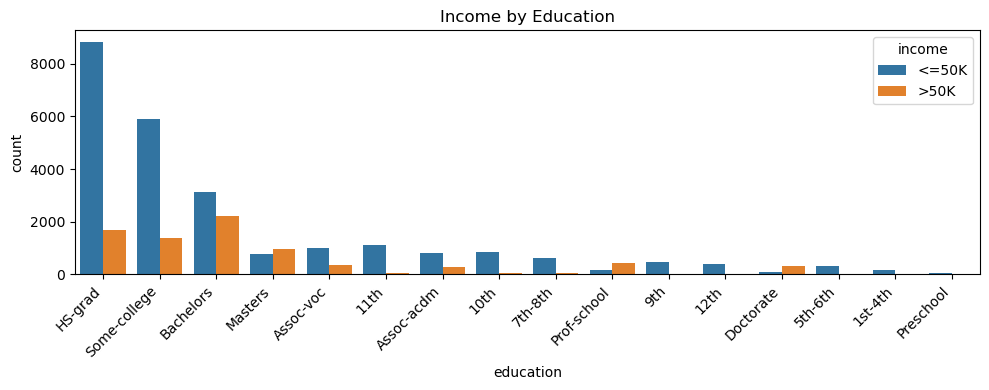

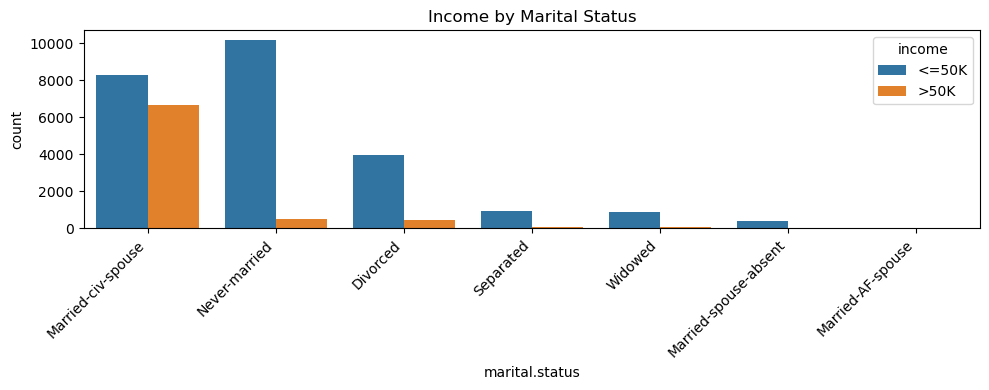

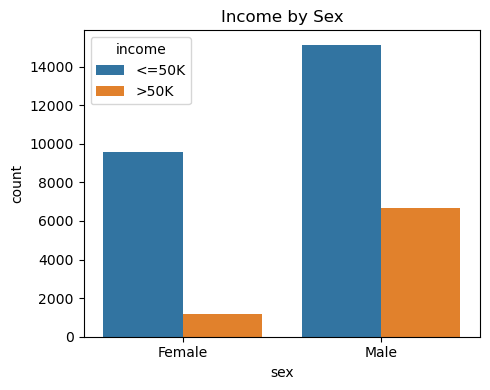

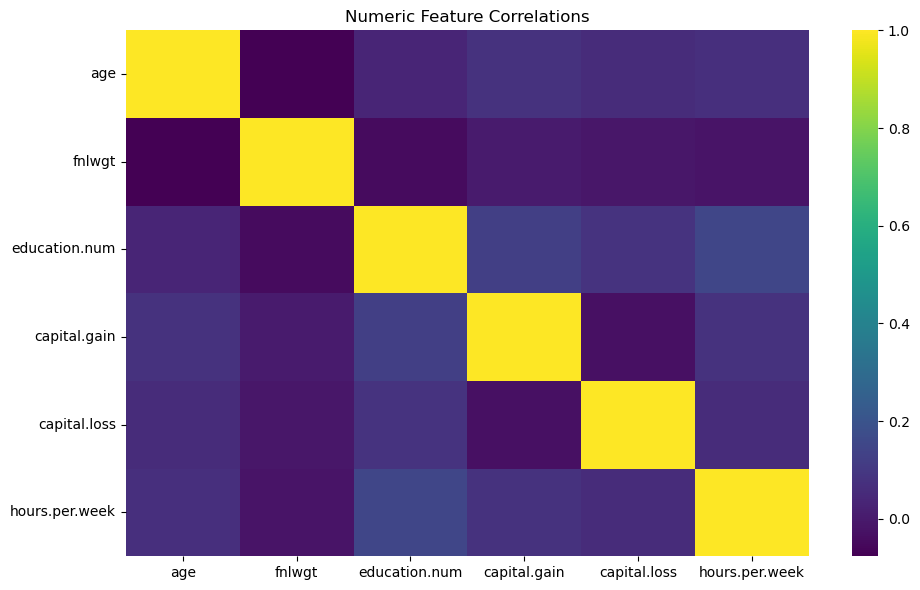

In [5]:

# For continuous vs target, make age bins to countplot
df['age_bin'] = pd.cut(df['age'], bins=[0,20,30,40,50,60,100], right=False)

# Countplot: Income across age_bin
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='age_bin', hue='income')
plt.title('Income by Age Bin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Countplot: Income across Education
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='education', hue='income', order=df['education'].value_counts().index)
plt.title('Income by Education')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Countplot: Income across Marital Status
if 'marital.status' in df.columns:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x='marital.status', hue='income', order=df['marital.status'].value_counts().index)
    plt.title('Income by Marital Status')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Countplot: Income across Sex
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='sex', hue='income')
plt.title('Income by Sex')
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric columns only)
plt.figure(figsize=(10,6))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=False, cmap='viridis')
plt.title('Numeric Feature Correlations')
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
from pandas.api.types import is_categorical_dtype, is_interval_dtype

interval_like_cols = []
for c in df.columns:
    if is_interval_dtype(df[c]):
        interval_like_cols.append(c)
    elif is_categorical_dtype(df[c]) and isinstance(df[c].cat.categories, pd.IntervalIndex):
        interval_like_cols.append(c)

for c in interval_like_cols:
    df[c] = df[c].astype(str)  # convert intervals to strings so they can be label-encoded
    df[c]


## 4) Preprocess: encode categoricals, scale numerics, fix imbalance

In [7]:

# Separate target and features
target_col = 'income'
assert target_col in df.columns, f"Target column '{target_col}' not found. Columns: {df.columns.tolist()}"

# Label-encode all object columns (as required)
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define X and y
X = df.drop(columns=[target_col])
y = df[target_col]

# Train-test split: 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Handle class imbalance (training set only)
if IMB_AVAILABLE:
    ros = RandomOverSampler(random_state=42)
    X_train_bal, y_train_bal = ros.fit_resample(X_train_scaled, y_train)
    print("Applied RandomOverSampler. Class distribution after balancing:")
    print(pd.Series(y_train_bal).value_counts())
else:
    X_train_bal, y_train_bal = X_train_scaled, y_train
    print("Proceeding without oversampling (imblearn not available).")


Applied RandomOverSampler. Class distribution after balancing:
income
1    19775
0    19775
Name: count, dtype: int64


## 5) Modeling: train 6 classifiers

In [8]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results = []
best_name, best_f1, best_model = None, -1.0, None

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='weighted')  # weighted to handle class imbalance
    results.append((name, acc, f1))
    if f1 > best_f1:
        best_f1, best_name, best_model = f1, name, model

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1_weighted']).sort_values(by='F1_weighted', ascending=False)
display(results_df)
print(f"Best model by F1 (weighted): {best_name} (F1={best_f1:.4f})")


,Model,Accuracy,F1_weighted
5,RandomForest,0.849225,0.849192
4,DecisionTree,0.816828,0.816364
3,NaiveBayes,0.819438,0.809155
2,SVM,0.793951,0.806581
1,KNN,0.775372,0.788194
0,LogisticRegression,0.774758,0.787303


Best model by F1 (weighted): RandomForest (F1=0.8492)


## 6) Detailed evaluation of best model

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4945
           1       0.69      0.69      0.69      1568

    accuracy                           0.85      6513
   macro avg       0.79      0.79      0.79      6513
weighted avg       0.85      0.85      0.85      6513



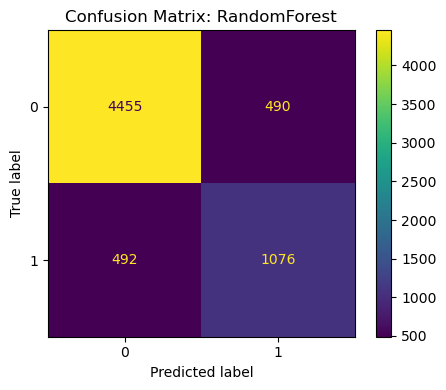

In [9]:

# Refit best on balanced train (already fitted), show report & confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_best = best_model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax)
plt.title(f'Confusion Matrix: {best_name}')
plt.tight_layout()
plt.show()


## 7) Save artifacts & processed dataset

In [10]:

artifacts = {
    "scaler": scaler,
    "label_encoders": label_encoders,
    "feature_columns": X.columns.tolist(),
    "target_encoder": label_encoders.get('Income', None)
}

joblib.dump(best_model, os.path.join(SAVE_DIR, "best_model.joblib"))
joblib.dump(artifacts,  os.path.join(SAVE_DIR, "preprocess_artifacts.joblib"))

# Save processed dataset (post-encoding)
processed_path = os.path.join(SAVE_DIR, "adult_processed.csv")
df.to_csv(processed_path, index=False)

print("Saved:")
print(" -", os.path.join(SAVE_DIR, "best_model.joblib"))
print(" -", os.path.join(SAVE_DIR, "preprocess_artifacts.joblib"))
print(" -", processed_path)


Saved:
 - /mnt/data\best_model.joblib
 - /mnt/data\preprocess_artifacts.joblib
 - /mnt/data\adult_processed.csv


## 8) Cross-validation & basic hyperparameter tuning

In [11]:

#5-fold CV on RandomForest (on balanced training set)
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=200, random_state=42)
cv_scores = cross_val_score(rf, X_train_bal, y_train_bal, cv=5, scoring='f1_weighted')
print("RandomForest 5-fold CV F1 (weighted):", cv_scores, "Mean:", cv_scores.mean())




RandomForest 5-fold CV F1 (weighted): [0.92668964 0.92936012 0.94203154 0.9397321  0.93755868] Mean: 0.9350744159364666


In [14]:
# SVM 
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

# TRAIN-ONLY balanced & scaled data:
# X_train_bal, y_train_bal, X_test_scaled, y_test

lin_svm = LinearSVC(random_state=42, max_iter=5000)  # fast, no probability
lin_svm.fit(X_train_bal, y_train_bal)

svm_preds = lin_svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_preds)
svm_f1  = f1_score(y_test, svm_preds, average="weighted")
print(f"LinearSVC -> Acc: {svm_acc:.3f}, F1_w: {svm_f1:.3f}")


LinearSVC -> Acc: 0.773, F1_w: 0.786


In [19]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Base features BEFORE any balancing; let the pipeline handle ROS per fold
# X, y should be your original (pre-split) features/labels after encoding

pipe_lin = ImbPipeline([
    ("ros", RandomOverSampler(random_state=42)),
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LinearSVC(random_state=42, max_iter=5000))
])

pipe_rf = ImbPipeline([
    ("ros", RandomOverSampler(random_state=42)),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

lin_cv = cross_val_score(pipe_lin, X, y, scoring="f1_weighted", cv=cv, n_jobs=-1)
rf_cv  = cross_val_score(pipe_rf,  X, y, scoring="f1_weighted", cv=cv, n_jobs=-1)

print(f"LinearSVC 5-fold F1_w: {lin_cv.mean():.3f} ± {lin_cv.std():.3f}")
print(f"RandomForest 5-fold F1_w: {rf_cv.mean():.3f} ± {rf_cv.std():.3f}")


LinearSVC 5-fold F1_w: 0.783 ± 0.005
RandomForest 5-fold F1_w: 0.849 ± 0.004



### Notes
- Label encoding is used for **all** categorical columns.
- Scaling uses `StandardScaler` on **features only**.  
- Oversampling is applied **only to the training set** to avoid leakage.  
- Best model is picked by **F1 (weighted)** to respect class imbalance.  
- All artifacts are saved in `/mnt/data/` so can reuse them for inference.
